<a href="https://colab.research.google.com/github/LaZoark/anomaly_detection/blob/main/%5B%E8%BB%B8%E6%89%BF%E7%AB%B6%E8%B3%BD%5Ddetect_predict_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import os
import pandas as pd
import numpy as np
import random
import datetime

import tensorflow as tf
import keras
from keras.layers import Dense
from keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import joblib

# import pymongo
# from pymongo import MongoClient
# import psycopg2
# from psycopg2.extras import execute_values

from matplotlib import pyplot as plt

# For reproducible results
# tf.random.set_seed(123456)
np.random.seed(123456)
random.seed(123456)

# Envs setting

In [202]:
# # deviceID
# deviceID = 'FF556D31'

# model saving path
save_path = 'training_model/'

# create model saving folder
if not os.path.exists('./training_model'):
    os.makedirs('./training_model')

In [203]:
config = {}
envs = {
    # "deviceID": 'FF548D29',
    "deviceID": 'bearing_comp',
    # "deviceID": 'JNU_bearing',
}

In [204]:
for env, default in envs.items():
    config.update({
        env: os.getenv(env, default)
    })
print(config)

{'deviceID': 'bearing_comp'}


In [205]:
E_model_name = config['deviceID'] +"_pretrain_encoder.h5"
D_model_name = config['deviceID'] +"_pretrain_decoder.h5"

M_model_name = config['deviceID'] +"_metatrain_encoder.h5"
MF_model_name = config['deviceID'] +"_metatrain_decoder.h5"

PF_model_name = config['deviceID'] +"_ft_decoder.h5"
MFR_model_name = config['deviceID'] +"_meta_reft_decoder.h5"

scalers = config['deviceID'] +"_scaler.h5"
train_dataset = config['deviceID'] +"_Train.csv"
inference_dataset = config['deviceID'] +"_Test.csv"
Inference_result_name = config['deviceID'] +"_inference_result"

In [206]:
metatrain_encoder_model = save_path + M_model_name
metatrain_refinetune_decoder_model = save_path + MFR_model_name

pretrain_encoder_model = save_path + E_model_name
pretrain_decoder_model = save_path + D_model_name

metatrain_finetune_decoder_model = save_path + MF_model_name
pretrain_finetune_decoder_model = save_path + PF_model_name

pretrain_scaler_name = save_path + scalers
Train_dataset = train_dataset

# Load 7 days Data from datahub

In [207]:
if envs['deviceID'] == 'FF548D29':
    # data = download_from_datahub(config['deviceID'])
    from google.colab import drive
    drive.mount('/content/drive')
elif envs['deviceID'] == 'bearing_comp':
    # 軸承競賽 train.csv
    !wget https://github.com/dreamingfish2011/ml_dl/raw/master/com/self/ml/classify/bearing/train.csv
elif envs['deviceID'] == 'JNU_bearing':
    # 江南大學 bearing datasets
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/B600.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/B800.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/B1000.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/IR600.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/IR800.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/IR1000.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/OR600.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/OR800.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/OR1000.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/N600.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/N800.csv
    ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/N1000.csv

--2022-05-23 15:00:02--  https://github.com/dreamingfish2011/ml_dl/raw/master/com/self/ml/classify/bearing/train.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dreamingfish2011/ml_dl/master/com/self/ml/classify/bearing/train.csv [following]
--2022-05-23 15:00:02--  https://raw.githubusercontent.com/dreamingfish2011/ml_dl/master/com/self/ml/classify/bearing/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96539633 (92M) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>]  92.07M   203MB/s    in 0.5s    

2022-05-23 15:00:03 (203 MB/s) - ‘train.csv.2

In [208]:
_path = ['/content/drive/MyDrive/[研華科技]水泵聯軸器與馬達raw data/fine_水泵聯軸器_20211116.csv',
         '/content/drive/MyDrive/[研華科技]水泵聯軸器與馬達raw data/水泵馬達_20211116.csv',
         '/content/train.csv',
         '/content/N600.csv',
]

if envs['deviceID'] == 'FF548D29':
    # data = pd.read_csv(_path[0], encoding='utf-8')
    data = pd.read_csv(_path[1], encoding='utf-8')
elif envs['deviceID'] == 'JNU_bearing':
    data = pd.read_csv(_path[3], encoding='utf-8')
elif envs['deviceID'] == 'bearing_comp':
    data = pd.read_csv(_path[2], encoding='utf-8', index_col='id')

In [209]:
def delete_outlier(df, name):    
    df_value = df[name]
    s = df_value.copy()
    zscore = s - s.mean()
    sigma = s.std()
    df['isOutlier'] = zscore.abs() > 6 * sigma
    #找出在3 sigma內的正常值
    df_in = df[df['isOutlier'] == False]
    df_in2 = df_in.drop(['isOutlier'],axis=1)

    return df_in2

In [210]:
#drop "id"
# data.drop(data.columns[0], axis=1, inplace=True)
data

,1,2,3,4,5,6,7,8,9,10,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.563650,1.069229,-0.837759,-1.122021,0.433296,0.770755,-0.477153,-0.588421,0.455224,0.555122,...,-0.050761,0.220506,0.036548,-0.097461,-0.084060,-0.007716,-0.049949,-0.018274,0.021523,7
2,0.061333,0.058830,0.056952,0.068634,0.073433,0.072390,0.042975,-0.007302,-0.026286,-0.006050,...,0.061333,0.107437,0.104516,0.063419,-0.014394,-0.048607,-0.009388,0.058830,0.129342,0
3,0.035736,0.010964,-0.164872,-0.167714,-0.125075,-0.104771,-0.016650,0.151471,0.137258,0.045076,...,4.272044,-1.991455,-2.922208,1.937039,0.704156,-2.085667,0.203044,0.739892,-2.149829,9
4,-0.046700,0.060913,0.009340,-0.093400,-0.067817,0.022335,0.006091,-0.076751,-0.032893,0.023553,...,0.095025,-0.000406,0.091776,0.074314,-0.082842,-0.110050,-0.028020,0.025990,-0.050355,9
5,0.162922,-0.377662,0.014457,0.565437,-0.203369,-0.511508,0.410961,0.228546,-0.515244,0.013157,...,-0.093563,-0.263632,0.114517,0.209541,-0.184851,-0.075370,0.286211,0.005685,-0.223348,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,-0.106811,-0.113487,-0.098884,-0.070929,-0.054031,-0.011265,0.031710,0.051111,0.051111,0.015646,...,0.003964,-0.002712,-0.011891,-0.003338,0.030458,0.051319,0.042349,0.010639,-0.031918,0
789,1.775416,2.268407,-0.783750,-2.423126,-0.356139,2.712261,1.358364,-2.023942,-1.642625,1.703538,...,-0.179897,0.879586,0.576645,-0.486899,-0.652583,0.233094,0.760196,-0.030050,-0.861312,7
790,-0.320809,0.141319,0.962022,-0.022335,-0.903139,0.454412,1.038773,-0.651365,-0.790653,0.815830,...,0.071471,0.077563,0.168933,0.131572,0.032487,0.071878,0.000406,-0.067817,0.006091,9


In [211]:
print(data.columns)
if envs['deviceID'] == 'FF548D29':
    try:
        data['INV.HZ'].plot()
        data['INV.KW'].plot()
    except:
        data[' INV.HZ'].plot()
        data[' INV.KW'].plot()
    plt.legend()
elif envs['deviceID'] == 'JNU_bearing':
    data.plot()

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '5992', '5993', '5994', '5995', '5996', '5997', '5998', '5999', '6000',
       'label'],
      dtype='object', length=6001)


In [212]:
if envs['deviceID'] == 'FF548D29':
    feature24=['X_OAVelocity', 'Y_OAVelocity', 'Z_OAVelocity',
                'X_Peakmg', 'Y_Peakmg', 'Z_Peakmg', 
                'X_RMSmg', 'Y_RMSmg', 'Z_RMSmg',
                'X_Kurtosis', 'Y_Kurtosis', 'Z_Kurtosis', 
                'X_CrestFactor', 'Y_CrestFactor', 'Z_CrestFactor', 
                'X_Skewness', 'Y_Skewness','Z_Skewness',
                'X_Deviation', 'Y_Deviation', 'Z_Deviation',
                'X_Displacement', 'Y_Displacement', 'Z_Displacement']


    # show NA rows in the dataframe
    df_NA = data[data.isnull().values==True]   #显示存在缺失值的行列

    data = data.dropna() #剔除缺失行
    data = data.drop_duplicates() #剔除重复行

    # delete outlier rows 剔除异常行
    
    for i in range(len(feature24)):
        data = delete_outlier(data, feature24[i])

# 備份初步清理過後的原始資料
rawdata = data.copy()

In [213]:
def plot_data(_data):
    data_columns = list(_data.columns)
    for i in data_columns:
        try:
            fig, ax = plt.subplots()
            plt.title(i)
            _data[i].plot(ax=ax)
            plt.show()
        except:
            print(i)

# plot_data(rawdata[:][0])

In [214]:
# data[0:5000].plot()

In [215]:
rawdata.iloc[1]
if envs['deviceID'] == 'bearing_comp':
    raw_label = rawdata['label']
    print(raw_label)

id
1      7
2      0
3      9
4      9
5      7
      ..
788    0
789    7
790    9
791    3
792    3
Name: label, Length: 792, dtype: int64


In [216]:
if envs['deviceID'] == 'FF548D29':
    data_24_no_abnormal = data.reindex(columns=feature24)
    print('data_24_no_abnormal: ', data_24_no_abnormal.shape)
elif envs['deviceID'] == 'JNU_bearing':
    data_normal = data.copy()
elif envs['deviceID'] == 'bearing_comp':
    data_normal = rawdata[rawdata['label']==0]
    data_normal.drop('label', axis=1, inplace=True)
    print('normal data: ', data_normal.shape)

normal data:  (177, 6000)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Normailize

In [217]:
if envs['deviceID'] == 'FF548D29':
    Xy_drop = data_24_no_abnormal.copy()
else:
    Xy_drop = data_normal.copy()

scaler = MinMaxScaler().fit(Xy_drop)
norm_data = scaler.transform(Xy_drop)
norm_data = pd.DataFrame(norm_data)

In [218]:
# Normailze scaler save to assigned folder path
joblib.dump(scaler, pretrain_scaler_name)

['training_model/bearing_comp_scaler.h5']

# Make dataset

In [219]:
pid=0
# Normalize

#P(Pretrain) M(Metatrain)
P_M_data = int(norm_data.shape[0]*0.4)
#F(Finetune) T(Test)
F_T_data = int(norm_data.shape[0]*0.2)

t1P = P_M_data
t1M = t1P + P_M_data
t1F = t1M + F_T_data
# t1T = t1F + F_T_data
# t2M = t1T + P_M_data
# t2F = t2M + F_T_data
# t2T = t2F + F_T_data
# t3F = t2T + F_T_data
# t3T = t3F + F_T_data

######################### t1 data##############################################

# Training data for pretrain stage
norm_Xy_drop_df = norm_data.iloc[0:t1P]

# 將資料分成Train與Test
x_train, x_test = train_test_split(norm_Xy_drop_df, test_size=0.2, random_state=0)

# save splited set
if not os.path.exists('./norm_data/pretrain/%d'%(pid+1)):
    os.makedirs('./norm_data/pretrain/%d'%(pid+1))
x_train.to_csv('./norm_data/pretrain/%d/train.csv'%(pid+1), index=False)
x_test.to_csv('./norm_data/pretrain/%d/test.csv'%(pid+1), index=False)


# Training data for meta stage
norm_Xy_drop_df = norm_data.iloc[t1P:t1M]

# split train and test set
x_train, x_test = train_test_split(norm_Xy_drop_df, test_size=0.2, random_state=0)

# save splited set
if not os.path.exists('./norm_data/meta/%d'%(pid+1)):
    os.makedirs('./norm_data/meta/%d'%(pid+1))
x_train.to_csv('./norm_data/meta/%d/train.csv'%(pid+1), index=False)
x_test.to_csv('./norm_data/meta/%d/test.csv'%(pid+1), index=False)

# Training data for ft stage
norm_Xy_drop_df = norm_data.iloc[t1M:t1F] 

# split train and test set
x_train, x_test = train_test_split(norm_Xy_drop_df, test_size=0.8, random_state=0)

# save splited set
if not os.path.exists('./norm_data/ft/%d'%(pid+1)):
    os.makedirs('./norm_data/ft/%d'%(pid+1))
x_train.to_csv('./norm_data/ft/%d/train.csv'%(pid+1), index=False)
x_test.to_csv('./norm_data/ft/%d/test.csv'%(pid+1), index=False)


# # Test data
# x_test = norm_data.iloc[t1F:t1T]

# # save splited set
# if not os.path.exists('./norm_data/test/%d'%(pid+1)):
#     os.makedirs('./norm_data/test/%d'%(pid+1))
# x_test.to_csv('./norm_data/test/%d/test.csv'%(pid+1), index=False)

print('t1 ok')

t1 ok


In [220]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
161,0.760000,0.980030,0.926812,0.653278,0.608592,0.691150,0.643305,0.633851,0.509346,0.518496,...,0.932649,0.864055,0.804909,0.736722,0.690985,0.684044,0.705472,0.714770,0.580974,0.568796
159,0.697419,0.468935,0.325123,0.324867,0.507757,0.716436,0.639316,0.610248,0.584780,0.662762,...,0.744708,0.616359,0.604783,0.635637,0.548636,0.438125,0.459764,0.590108,0.750283,0.847052
149,0.630323,0.682692,0.788177,0.754282,0.757757,0.685731,0.466667,0.518710,0.610814,0.695438,...,0.463759,0.509793,0.471366,0.316962,0.072361,0.104792,0.366416,0.668022,0.745187,0.699631
147,0.470968,0.365385,0.289937,0.243946,0.360979,0.528597,0.437037,0.442142,0.367156,0.446979,...,0.407312,0.464862,0.538074,0.572244,0.495848,0.355450,0.292382,0.272358,0.406569,0.509214
173,0.098065,0.159763,0.257565,0.367986,0.493437,0.659843,0.637607,0.656304,0.594126,0.503083,...,0.402822,0.531106,0.619887,0.727013,0.736062,0.717746,0.660944,0.448509,0.240657,0.010442
143,0.280000,0.147929,0.096411,0.148848,0.298329,0.510536,0.485470,0.577432,0.753672,0.925401,...,0.359205,0.396313,0.408433,0.449457,0.336299,0.360190,0.532725,0.653794,0.657418,0.495086
140,0.289677,0.240385,0.330049,0.379209,0.454057,0.463576,0.247293,0.230858,0.281709,0.491369,...,0.822963,0.850230,0.964128,0.886351,0.664294,0.447077,0.458691,0.606369,0.698754,0.737101


# Pretrain stage

In [221]:
pretrain_train_path = './norm_data/pretrain/1/train.csv'
pretrain_val_path = './norm_data/pretrain/1/test.csv'
x_train = pd.read_csv(pretrain_train_path, dtype=np.float32)
x_test = pd.read_csv(pretrain_val_path, dtype=np.float32)

In [222]:
# nb_epoch_number = 300
nb_epoch_number = 50

In [223]:
nb_epoch = nb_epoch_number #50
if envs['deviceID'] == 'FF548D29':
    batch_size = 10
elif envs['deviceID'] == 'JNU_bearing':
    batch_size = 64
else:
    batch_size = 10
input_dim = x_train.shape[1] #num of predictor variables,  (24)
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
lr_regularizers = 1e-3

input_layer = keras.layers.Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu", 
                       activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

encoder = keras.Model(input_layer, encoder_output, name="encoder")

decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

autoencoder_input = keras.layers.Input(shape=(input_dim, ), name="input")
encoded_sig = encoder(autoencoder_input)
decoded_sig = decoder(encoded_sig)
autoencoder = keras.models.Model(autoencoder_input, decoded_sig, name="autoencoder")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6000)]            0         
                                                                 
 encoder (Functional)        (None, 4)                 192732    
                                                                 
 decoder (Functional)        (None, 6000)              198728    
                                                                 
Total params: 391,460
Trainable params: 391,460
Non-trainable params: 0
_________________________________________________________________


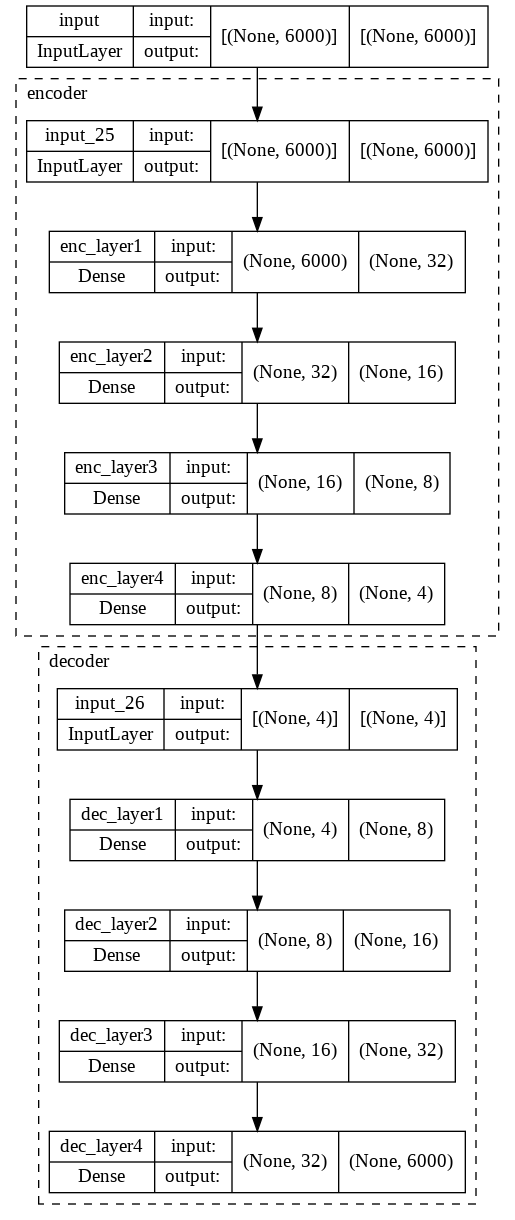

In [224]:
autoencoder.summary()

tf.keras.utils.plot_model(autoencoder, to_file='model_1.png', show_shapes=True,
                        expand_nested=True,
                        show_layer_activations=True,
                        )

In [225]:
learning_rate = 3e-4
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

autoencoder.compile(loss='mean_squared_error', optimizer=adam)

if envs['deviceID'] == 'FF548D29':
    patience = 50
elif envs['deviceID'] == 'JNU_bearing':
    patience = 10
else:
    patience = 30
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [226]:
# 因為AE要重建input，希望透過重建誤差來找到異常
AE_history = autoencoder.fit( x_train.to_numpy(), #input y=0的資料
                              x_train.to_numpy(), #與decoder比對 y=0的資料
                              epochs=nb_epoch,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test.to_numpy(), x_test.to_numpy()),
                              verbose=1,
                              callbacks=[es]).history

Epoch 1/50
6/6 [==============================] - 1s 41ms/step - loss: 0.3129 - val_loss: 0.3078
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.3084 - val_loss: 0.3059
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3064 - val_loss: 0.3038
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3043 - val_loss: 0.3016
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.3020 - val_loss: 0.2990
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.2993 - val_loss: 0.2961
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 0.2962 - val_loss: 0.2927
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.2925 - val_loss: 0.2886
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 0.2882 - val_loss: 0.2838
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 0.2831 - val_loss: 0.2782
Epoch 11/50
6/6 [============

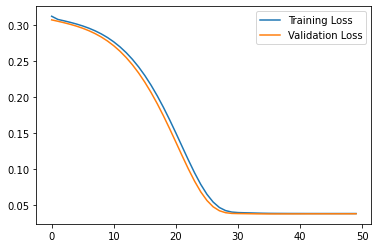

In [227]:
plt.plot(AE_history["loss"], label="Training Loss")
plt.plot(AE_history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [228]:
encoder.save(pretrain_encoder_model) #save encoder weights
decoder.save(pretrain_decoder_model) #save decoder weights

In [229]:
# RMSE受異常值的影響更大
def RMSE_cal(model,x,y):
    ypred = model.predict(x)
    MSE = mean_squared_error(y, ypred)
    RMSE = np.sqrt(MSE)
    return RMSE

In [230]:
trainRMSE = RMSE_cal(autoencoder,x_train.to_numpy(), x_train.to_numpy())
print('trainRMSE: ', trainRMSE)

testRMSE = RMSE_cal(autoencoder,x_test.to_numpy(), x_test.to_numpy())
print('testRMSE: ', testRMSE)

trainRMSE:  0.19412765
testRMSE:  0.19333944


# Meta-learning Stage

In [231]:
meta_train_path = './norm_data/meta/1/train.csv'
meta_val_path = './norm_data/meta/1/test.csv'
x_train = pd.read_csv(pretrain_train_path, dtype=np.float32)
x_test = pd.read_csv(pretrain_val_path, dtype=np.float32)

x_train_list = [x_train, pd.read_csv(meta_train_path, dtype=np.float32)]
x_test_list = [x_test, pd.read_csv(meta_val_path, dtype=np.float32)]

num_file = 1
# for i in range(num_file):
#     meta_train_path = './norm_data/meta/%d/train.csv'%(i+1)
#     meta_val_path = './norm_data/meta/%d/test.csv'%(i+1)
#     x_train_list.append(pd.read_csv(meta_train_path, dtype=np.float32))
#     x_test_list.append(pd.read_csv(meta_val_path, dtype=np.float32))

In [232]:
nb_epoch = nb_epoch_number
if envs['deviceID'] == 'FF548D29':
    batch_size = 10
elif envs['deviceID'] == 'JNU_bearing':
    batch_size = 64
else:
    batch_size = 10
input_dim = x_train_list[0].shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
lr_regularizers = 1e-3

In [233]:
train_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_train_list])).shuffle(len(x_train_list[0])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_test_list])).batch(1)

In [234]:
input_layer = keras.layers.Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

encoder = keras.Model(input_layer, encoder_output, name="encoder")

decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

encoder.compile() # 避免報錯(warning)
decoder.compile()
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 6000)]            0         
                                                                 
 enc_layer1 (Dense)          (None, 32)                192032    
                                                                 
 enc_layer2 (Dense)          (None, 16)                528       
                                                                 
 enc_layer3 (Dense)          (None, 8)                 136       
                                                                 
 enc_layer4 (Dense)          (None, 4)                 36        
                                                                 
Total params: 192,732
Trainable params: 192,732
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
____________________________________

In [235]:
encoder.load_weights(pretrain_encoder_model, by_name=True)
decoder_list = []
for i in range(2):
    decoder_list.append(keras.models.clone_model(decoder))
    decoder_list[-1].load_weights(pretrain_decoder_model, by_name=True)

In [236]:
learning_rate = 1e-5
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = keras.losses.MeanSquaredError()

In [237]:
best_val_loss = 999

for ep in range(nb_epoch):
    for bid, x in enumerate(train_dataset):
        #Phase 1: Fix enc, train different dec with only one batch
        if bid == 0:
            x_dec = x

        for i in range(num_file):
            with tf.GradientTape() as tape:
                hidden = encoder(x_dec[i])
                recon = decoder_list[i](hidden)
                loss = loss_fn(x_dec[i], recon)

            gradients = tape.gradient(loss, decoder_list[i].trainable_weights)
            adam.apply_gradients(zip(gradients, decoder_list[i].trainable_weights))

        #Phase 2: Fix dec, train meta encoder
        if bid != 0:
            for i in range(2):
                with tf.GradientTape() as tape:
                    hidden = encoder(x[i])
                    recon = decoder_list[i](hidden)
                    loss = loss_fn(x[i], recon)

                gradients = tape.gradient(loss, encoder.trainable_weights)
                adam.apply_gradients(zip(gradients, encoder.trainable_weights))


    val_loss = []
    for bid, x in enumerate(val_dataset):
        for i in range(num_file):   
            hidden = encoder(x[i])
            recon = decoder_list[i](hidden)
            loss = loss_fn(x[i], recon)
            val_loss.append(loss.numpy())
            
    print("\nEpoch: %d\tval_loss: %f"%(ep+1, np.mean(val_loss)), end='\t')
    
    if np.mean(val_loss) < best_val_loss:           # 跌代出最好的loss
        encoder.save(metatrain_encoder_model)
        best_val_loss = np.mean(val_loss)
        print("Save best model at ep %d"%(ep+1), end='')


Epoch: 1	val_loss: 0.037379	Save best model at ep 1
Epoch: 2	val_loss: 0.037374	Save best model at ep 2
Epoch: 3	val_loss: 0.037363	Save best model at ep 3
Epoch: 4	val_loss: 0.037351	Save best model at ep 4
Epoch: 5	val_loss: 0.037347	Save best model at ep 5
Epoch: 6	val_loss: 0.037344	Save best model at ep 6
Epoch: 7	val_loss: 0.037342	Save best model at ep 7
Epoch: 8	val_loss: 0.037337	Save best model at ep 8
Epoch: 9	val_loss: 0.037346	
Epoch: 10	val_loss: 0.037359	
Epoch: 11	val_loss: 0.037372	
Epoch: 12	val_loss: 0.037384	
Epoch: 13	val_loss: 0.037394	
Epoch: 14	val_loss: 0.037395	
Epoch: 15	val_loss: 0.037383	
Epoch: 16	val_loss: 0.037378	
Epoch: 17	val_loss: 0.037374	
Epoch: 18	val_loss: 0.037385	
Epoch: 19	val_loss: 0.037401	
Epoch: 20	val_loss: 0.037411	
Epoch: 21	val_loss: 0.037414	
Epoch: 22	val_loss: 0.037403	
Epoch: 23	val_loss: 0.037392	
Epoch: 24	val_loss: 0.037390	
Epoch: 25	val_loss: 0.037393	
Epoch: 26	val_loss: 0.037397	
Epoch: 27	val_loss: 0.037403	
Epoch: 28	val_

# Fine-tuning Stage (Meta)

In [238]:
x_train_list = []
x_test_list = []
# num_file = 3
num_file = 1
for i in range(num_file):
    ft_train_path = './norm_data/ft/%d/train.csv'%(i+1)
    ft_val_path = './norm_data/ft/%d/test.csv'%(i+1)
    x_train_list.append(pd.read_csv(ft_train_path, dtype=np.float32))
    x_test_list.append(pd.read_csv(ft_val_path, dtype=np.float32))

In [239]:
print(x_train_list[0].shape)
print(x_test_list[0].shape)

(7, 6000)
(28, 6000)


In [240]:
nb_epoch = nb_epoch_number
if envs['deviceID'] == 'FF548D29':
    batch_size = 10
elif envs['deviceID'] == 'JNU_bearing':
    batch_size = 128
else:
    batch_size = 10
#batch_size = 1
input_dim = x_train_list[0].shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
lr_regularizers = 1e-3

In [241]:
train_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_train_list])).shuffle(len(x_train_list[0])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_test_list])).batch(1)

In [242]:
input_layer = keras.layers.Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

encoder = keras.Model(input_layer, encoder_output, name="encoder")

decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

# encoder.compile()
# decoder.compile()
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 6000)]            0         
                                                                 
 enc_layer1 (Dense)          (None, 32)                192032    
                                                                 
 enc_layer2 (Dense)          (None, 16)                528       
                                                                 
 enc_layer3 (Dense)          (None, 8)                 136       
                                                                 
 enc_layer4 (Dense)          (None, 4)                 36        
                                                                 
Total params: 192,732
Trainable params: 192,732
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
____________________________________

In [243]:
encoder.load_weights(metatrain_encoder_model, by_name=True)
decoder_list = []
for i in range(num_file):
    decoder_list.append(keras.models.clone_model(decoder))
    decoder_list[-1].load_weights(pretrain_decoder_model, by_name=True)
    decoder_list[i].compile()

In [244]:
learning_rate = 1e-5
adam = tf.keras.optimizers.Adam(lr=learning_rate)

loss_fn = tf.keras.losses.MeanSquaredError()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [245]:
for i in range(num_file):
    print(metatrain_finetune_decoder_model)

training_model/bearing_comp_metatrain_decoder.h5


In [246]:
best_val_loss = [999 for i in range(num_file)]

for ep in range(nb_epoch):
    for bid, x in enumerate(train_dataset):
        #only ft dec in ft stage
        for i in range(num_file):
            with tf.GradientTape() as tape:
                hidden = encoder(x[i])
                recon = decoder_list[i](hidden)
                loss = loss_fn(x[i], recon)

            gradients = tape.gradient(loss, decoder_list[i].trainable_weights)
            adam.apply_gradients(zip(gradients, decoder_list[i].trainable_weights))

    val_loss_list = [[] for i in range(num_file)]
    for bid, x in enumerate(val_dataset):
        for i in range(num_file):   
            hidden = encoder(x[i])
            recon = decoder_list[i](hidden)
            loss = loss_fn(x[i], recon)
            val_loss_list[i].append(loss.numpy())
    
    print("Epoch: %d"%(ep+1), end='\t')
    for i in range(num_file):
        print("file %d val_loss: %f"%(i+1, np.mean(val_loss_list[i])))

        if np.mean(val_loss_list[i]) < best_val_loss[i]:
            decoder_list[i].save(metatrain_finetune_decoder_model)
            best_val_loss[i] = np.mean(val_loss_list[i])

Epoch: 1	file 1 val_loss: 0.038925
Epoch: 2	file 1 val_loss: 0.038925
Epoch: 3	file 1 val_loss: 0.038926
Epoch: 4	file 1 val_loss: 0.038926
Epoch: 5	file 1 val_loss: 0.038927
Epoch: 6	file 1 val_loss: 0.038928
Epoch: 7	file 1 val_loss: 0.038928
Epoch: 8	file 1 val_loss: 0.038929
Epoch: 9	file 1 val_loss: 0.038929
Epoch: 10	file 1 val_loss: 0.038930
Epoch: 11	file 1 val_loss: 0.038930
Epoch: 12	file 1 val_loss: 0.038931
Epoch: 13	file 1 val_loss: 0.038931
Epoch: 14	file 1 val_loss: 0.038932
Epoch: 15	file 1 val_loss: 0.038932
Epoch: 16	file 1 val_loss: 0.038933
Epoch: 17	file 1 val_loss: 0.038933
Epoch: 18	file 1 val_loss: 0.038934
Epoch: 19	file 1 val_loss: 0.038934
Epoch: 20	file 1 val_loss: 0.038935
Epoch: 21	file 1 val_loss: 0.038935
Epoch: 22	file 1 val_loss: 0.038936
Epoch: 23	file 1 val_loss: 0.038936
Epoch: 24	file 1 val_loss: 0.038937
Epoch: 25	file 1 val_loss: 0.038938
Epoch: 26	file 1 val_loss: 0.038938
Epoch: 27	file 1 val_loss: 0.038939
Epoch: 28	file 1 val_loss: 0.038940
E

# Inference Trained Data

In [247]:
def make_encoder_decoder(input_dim):
    #input_dim = x_train.shape[1] #num of predictor variables, 
    encoding_dim = 32
    hidden_dim = int(encoding_dim / 2)
    lr_regularizers = 1e-3
    
    input_layer = keras.layers.Input(shape=(input_dim, ))
    x = Dense(encoding_dim, activation="relu", 
                    activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
    x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
    x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
    encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

    encoder = keras.Model(input_layer, encoder_output, name="encoder")

    decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
    x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
    x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
    x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
    decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

    decoder = keras.Model(decoder_input, decoder_output, name="decoder")
    return encoder, decoder

In [248]:
def run_inference_5min(test_dataset, encoder, decoder):
    test_loss_list = []
    for bid, x in enumerate(test_dataset):
        #for i in range(num_file):
            i=0 #data4
            loss = cal_NN_loss(x[i], encoder, decoder)
            RMSE = np.sqrt(loss.numpy())
            test_loss_list.append(RMSE)
    #print(np.sqrt(np.mean(test_loss_list[i])))
    return test_loss_list

In [249]:
def cal_NN_loss(in_data, encoder, decoder):
    hidden = encoder(in_data)
    recon = decoder(hidden)
    loss = loss_fn(in_data, recon)
    return loss

In [250]:
def RMSE_cal(model, x, y):
    ypred = model.predict(x)
    MSE = mean_squared_error(y, ypred)
    RMSE = np.sqrt(MSE)
    return RMSE

In [251]:
input_scaler = pretrain_scaler_name
E_input_model_name = metatrain_encoder_model
D_input_model_name = metatrain_finetune_decoder_model

inference_dataset = config['deviceID'] +"_Test.csv"
Inference_result_name = config['deviceID'] +"_inference_result"

In [252]:
E_input_model_name

'training_model/bearing_comp_metatrain_encoder.h5'

In [253]:
D_input_model_name

'training_model/bearing_comp_metatrain_decoder.h5'

In [254]:
if envs['deviceID'] == 'FF548D29':
    # features column order of autoencoder model
    model_features = ['X_OAVelocity', 'Y_OAVelocity', 'Z_OAVelocity',
                    'X_Peakmg', 'Y_Peakmg', 'Z_Peakmg', 'X_RMSmg', 'Y_RMSmg', 'Z_RMSmg',
                    'X_Kurtosis', 'Y_Kurtosis', 'Z_Kurtosis', 'X_CrestFactor',
                    'Y_CrestFactor', 'Z_CrestFactor', 'X_Skewness', 'Y_Skewness',
                    'Z_Skewness', 'X_Deviation', 'Y_Deviation', 'Z_Deviation',
                    'X_Displacement', 'Y_Displacement', 'Z_Displacement']
    # Preprocess data
    data = data.dropna()
    rawdata = data.copy()
    rawdata = rawdata.drop_duplicates()

    # delete outliers in 24 model feauture columns
    for i in range(len(model_features)):
        rawdata = delete_outlier(rawdata,model_features[i])

    # save a raw data copy for further dataframe combination
    rawdata_new = rawdata.copy()
    rawdata_new = rawdata_new[model_features]

    # Normalize data using pretrain scaler
    Xy_drop = rawdata_new.copy()
    norm_Xy_drop = scaler.transform(Xy_drop)
    norm_Xy_drop_df = pd.DataFrame(norm_Xy_drop)

    x_test_list = []
    x_test_list.append(norm_Xy_drop_df)
else:
    # Preprocess data
    data = data.dropna()
    rawdata = data.copy()
    rawdata = rawdata.drop_duplicates()
    # save a raw data copy for further dataframe combination
    rawdata_new = rawdata.copy()
    # Normalize data using pretrain scaler
    Xy_drop = rawdata_new.copy()
    if envs['deviceID'] == 'bearing_comp':
        Xy_drop.drop('label', axis=1, inplace=True)
    norm_Xy_drop = scaler.transform(Xy_drop)
    norm_Xy_drop_df = pd.DataFrame(norm_Xy_drop)
    x_test_list = []
    x_test_list.append(norm_Xy_drop_df)

test_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_test_list])).batch(1)

# Construct autoencoder model
input_dim = x_test_list[0].shape[1] #num of predictor variables, 
encoder, decoder = make_encoder_decoder(input_dim)

encoder.load_weights(E_input_model_name, by_name=True)
decoder.load_weights(D_input_model_name, by_name=True)

# Predict the inference dataset
X_rmse = run_inference_5min(test_dataset, encoder, decoder)
X_rmse_df=pd.DataFrame(X_rmse)
X_rmse_df.columns = ['degrading_level']

In [255]:
# X_rmse_df.values.mean()
# X_rmse_df[X_rmse_df.values>X_rmse_df.values.mean()]
if envs['deviceID'] == 'FF548D29':
    anomalies = np.where(X_rmse_df.values > X_rmse_df.values.mean(), 1, 0)
    anomalies = anomalies[:, 0]
    print(np.shape(np.where(anomalies != 0)))
elif envs['deviceID'] == 'bearing_comp':
    anomalies = raw_label[:760].values != 0
# elif envs['deviceID'] == 'JNU_bearing':

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


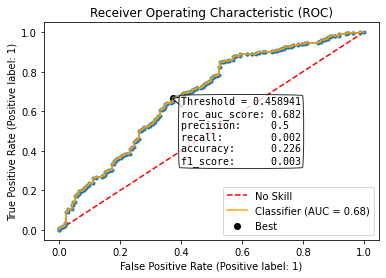

In [256]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay

# X_rmse_df.plot()
fpr, tpr, thresholds = roc_curve(anomalies, X_rmse_df)
roc_auc = roc_auc_score(anomalies, X_rmse_df)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
threshold = thresholds[ix]

predict_data = [0]*len(X_rmse_df)
for j in anomalies: predict_data[j] = 1

TN, FP, FN, TP = confusion_matrix(anomalies, predict_data).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FN + FP + TN)
f1_score = 2*TP / (2*TP + FP + FN)

fig_auc, ax = plt.subplots()
ax.set_title('Receiver Operating Characteristic (ROC)')
ax.plot([0, 1], [0, 1], 'r--', label='No Skill')
ax.plot(fpr, tpr, marker='.')
ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
RocCurveDisplay.from_predictions(anomalies, X_rmse_df, ax=ax, color='orange')
ax.annotate('Threshold = ' + str(threshold.round(6)) +
            '\n' + 'roc_auc_score:'.ljust(15) + str(roc_auc.round(3)) +
            '\n' + 'precision:'.ljust(15)     + str(precision.round(3)) +
            '\n' + 'recall:'.ljust(15)        + str(recall.round(3)) +
            '\n' + 'accuracy:'.ljust(15)      + str(accuracy.round(3)) +
            '\n' + 'f1_score:'.ljust(15)      + str(f1_score.round(3)),
             xy=([fpr[ix], tpr[ix]]), xytext=(0.4, 0.5),
             size=10, fontfamily='monospace', va="center", ha="left",
             bbox=dict(boxstyle="round4", fc="w", alpha=.8),
             arrowprops=dict(width=.8, connectionstyle="arc3,rad=-0.3", fc="w"))
plt.show()

# Upload 7 days inferenced training data to Postgresql

In [257]:
def make_list_rmse(df):
    list_rmse=[]
    
    # first append time-related column type
    list_rmse.append({'name':df.columns[0],
                      'type':'TIMESTAMPTZ'})
    
    # then iterate the rest of the columns type
    for i in range(1,len(df.columns)):
        data_type = str(df.dtypes[i]).upper()
        if data_type == 'FLOAT64':
            data_type = 'FLOAT'
        elif data_type == 'INT64':
            data_type = 'INTEGER'
        else:
            data_type = 'VARCHAR(64)'

        list_rmse.append({'name':df.columns[i],
                          'type':data_type})
    
    return list_rmse

In [258]:
def get_data_by_deltatime(data , deltatime):
    #data_deltatime = data.asfreq(freq= deltatime)
    #data_deltatime = data_deltatime.dropna()
    
    # save string type column 
    data_id = data['deviceId'].iloc[0]
    
    data.set_index("ts", inplace=True)  # New DataHub format
    data_deltatime = data.resample(rule = deltatime).mean()
    data_deltatime = data_deltatime.dropna()
    data_deltatime['deviceId'] = data_id
    
    return data_deltatime

In [259]:
# Combine the degrading_level result with original inference dataset then save
inference_data_raw = rawdata.copy()

rawdata_reindex = inference_data_raw.reset_index()
X_rawdata_rmse=pd.concat([rawdata_reindex, X_rmse_df], axis=1)
# X_rawdata_rmse = X_rawdata_rmse.drop(['index'],axis=1)

# sort the dataframe by ascending time order
# X_rawdata_rmse = X_rawdata_rmse.sort_values(by='ts', ascending=True)
# X_rawdata_rmse = X_rawdata_rmse.sort_values(by='Time', ascending=True)
X_rawdata_rmse.reset_index(drop=True, inplace=True)

# double check the column order of upload inference result
# final_order = ['ts','X_OAVelocity', 'Y_OAVelocity', 'Z_OAVelocity', 'Temp_Value',
#                 'X_Peakmg', 'Y_Peakmg', 'Z_Peakmg', 'X_RMSmg', 'Y_RMSmg', 'Z_RMSmg',
#                 'X_Kurtosis', 'Y_Kurtosis', 'Z_Kurtosis', 'X_CrestFactor',
#                 'Y_CrestFactor', 'Z_CrestFactor', 'X_Skewness', 'Y_Skewness',
#                 'Z_Skewness', 'X_Deviation', 'Y_Deviation', 'Z_Deviation',
#                 'X_Displacement', 'Y_Displacement', 'Z_Displacement', 'Battery_Level',
#                 'Power_source', 'Timestamp', 'Timestamp1', 'RSSI', 'SNR', 'Device_EUI',
#                 'Device_EUI1', 'Device_EUI2', 'Device_EUI3', 'Battery_Voltage',
#                 'deviceId', 'degrading_level']

# X_rawdata_rmse = X_rawdata_rmse[final_order]

In [260]:
X_rawdata_rmse

,id,1,2,3,4,5,6,7,8,9,...,5993,5994,5995,5996,5997,5998,5999,6000,label,degrading_level
0,1,0.563650,1.069229,-0.837759,-1.122021,0.433296,0.770755,-0.477153,-0.588421,0.455224,...,0.220506,0.036548,-0.097461,-0.084060,-0.007716,-0.049949,-0.018274,0.021523,7,1.893315
1,2,0.061333,0.058830,0.056952,0.068634,0.073433,0.072390,0.042975,-0.007302,-0.026286,...,0.107437,0.104516,0.063419,-0.014394,-0.048607,-0.009388,0.058830,0.129342,0,0.193738
2,3,0.035736,0.010964,-0.164872,-0.167714,-0.125075,-0.104771,-0.016650,0.151471,0.137258,...,-1.991455,-2.922208,1.937039,0.704156,-2.085667,0.203044,0.739892,-2.149829,9,1.571239
3,4,-0.046700,0.060913,0.009340,-0.093400,-0.067817,0.022335,0.006091,-0.076751,-0.032893,...,-0.000406,0.091776,0.074314,-0.082842,-0.110050,-0.028020,0.025990,-0.050355,9,1.103699
4,5,0.162922,-0.377662,0.014457,0.565437,-0.203369,-0.511508,0.410961,0.228546,-0.515244,...,-0.263632,0.114517,0.209541,-0.184851,-0.075370,0.286211,0.005685,-0.223348,7,0.700074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,788,-0.106811,-0.113487,-0.098884,-0.070929,-0.054031,-0.011265,0.031710,0.051111,0.051111,...,-0.002712,-0.011891,-0.003338,0.030458,0.051319,0.042349,0.010639,-0.031918,0,0.205433
756,789,1.775416,2.268407,-0.783750,-2.423126,-0.356139,2.712261,1.358364,-2.023942,-1.642625,...,0.879586,0.576645,-0.486899,-0.652583,0.233094,0.760196,-0.030050,-0.861312,7,2.553569
757,790,-0.320809,0.141319,0.962022,-0.022335,-0.903139,0.454412,1.038773,-0.651365,-0.790653,...,0.077563,0.168933,0.131572,0.032487,0.071878,0.000406,-0.067817,0.006091,9,1.110718
758,791,0.055878,0.104933,-0.030863,-0.087390,0.028589,-0.037360,-0.046294,-0.062375,-0.006660,...,-0.085116,0.097948,-0.007797,-0.085766,0.108507,0.074558,-0.053766,0.053604,3,0.312578


In [261]:
print(X_rawdata_rmse.columns)
# X_rawdata_rmse['DESCRIPION']

Index(['id', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '5993', '5994', '5995', '5996', '5997', '5998', '5999', '6000', 'label',
       'degrading_level'],
      dtype='object', length=6003)


<BarContainer object of 760 artists>

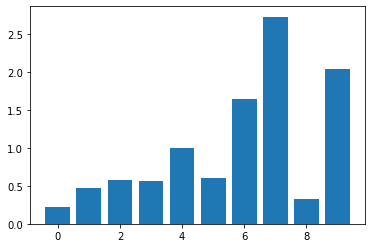

In [262]:
if envs['deviceID'] == 'FF548D29':
    check_index = ['index', 'degrading_level']
elif envs['deviceID'] == 'bearing_comp':
    check_index = ['label', 'degrading_level']
elif envs['deviceID'] == 'JNU_bearing':
    check_index = ['index', 'degrading_level']

_result = X_rawdata_rmse[check_index]
# _result.hist()
# fig, ax = plt.subplots()
# plt.plot(_result['label'], _result['degrading_level'])
plt.bar(x=_result[check_index[0]], height=_result[check_index[1]])

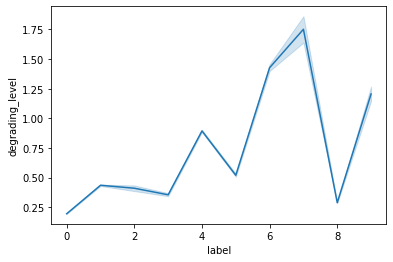

In [263]:
import seaborn as sns
# sns.pairplot(_result, hue='label', size=2.5);
# sns.pairplot(_result, size=4);
sns.lineplot(data=_result, 
             x=check_index[0], 
             y=check_index[1], 
             )

In [ ]:
# 將數據分割成十分鐘一筆
X_rawdata_rmse_deltatime = get_data_by_deltatime(X_rawdata_rmse ,'10min')
X_rawdata_rmse_deltatime = X_rawdata_rmse_deltatime.reset_index()
X_rawdata_rmse_deltatime = X_rawdata_rmse_deltatime[final_order]

In [ ]:
X_rawdata_rmse_deltatime

In [ ]:
# 上傳推理過後的 training data至 aifsphm.deviceID (rawdata+degrading level = 39 columns)
# *參考* https://wise-paas.advantech.com/zh-tw/marketplace/product/advantech.aifs-phm
'''upload_to_postgresDB(config['deviceID'] ,X_rawdata_rmse_deltatime)'''

# 上傳經過preprocessed之ts, Z_OAVelocity, degrading_level至aifsphm.deviceID_predict

In [ ]:
def phm_data_cleaning(data):
    '''1. Feature selection
       2. Time format conversion: UTC -> Local time
       3. Sort data by time, and remove data that overlaps in time
       4. Remove nan value
    '''
    col = ['ts', 'Z_OAVelocity', 'degrading_level']
    # data['ts'] = data['ts'] + datetime.timedelta(hours=8)
    
    # Sort data by time, and remove data that overlaps in time
    data = data.sort_values(by = 'ts', ascending=True)
    data.drop_duplicates("ts", "first", inplace = True)
    # Remove nan value
    data  = data.dropna(axis = 0, how = 'any')
    
    return data

def preprocess_historical(day_data):
    time = []
    rms = []
    rmse = []
    col = ['ts', 'Z_OAVelocity', 'degrading_level']
    for ii in range(len(day_data)):
        time1 = day_data[ii].iloc[0, 0]
        rms_sort = sorted(day_data[ii].Z_OAVelocity,reverse=True)
        rmse_sort = sorted(day_data[ii].degrading_level,reverse=True)
        rms_max = max(rms_sort[(round(len(day_data[ii])*0.1)):])
        rmse_max = max(rmse_sort[(round(len(day_data[ii])*0.1)):])
        time.append(time1), rms.append(rms_max), rmse.append(rmse_max)
    preprocess_data = pd.DataFrame([time, rms, rmse]).T
    preprocess_data.columns = col
    return preprocess_data

In [ ]:
data2 = phm_data_cleaning(X_rawdata_rmse_deltatime)
traindata_day = 1
for i in range(len(data2)-1):
    if data2['ts'].iloc[i].date() != data2['ts'].iloc[i+1].date():
        traindata_day = traindata_day + 1
            
# 創建空list, dataframe
day_data = {}
day_lst = {}
for v in range(traindata_day):
    day_data[v] = pd.DataFrame(columns=range(3))
    day_lst[v] = []
    
# 每天的時間長度可能不同，因此不同天存入不同的list, dataframe
traindata_day_index = 0
for i in range(len(data2)-1):
    if data2['ts'].iloc[i].date() == data2['ts'].iloc[i+1].date():
        day_lst[traindata_day_index].append(data2.iloc[i, :])
        day_data[traindata_day_index] = pd.DataFrame(day_lst[traindata_day_index])
    else:
        day_lst[traindata_day_index].append(data2.iloc[i, :])
        day_data[traindata_day_index] = pd.DataFrame(day_lst[traindata_day_index])
        traindata_day_index = traindata_day_index + 1
        
day_lst[traindata_day_index].append(data2.iloc[len(data2)-1, :])
day_data[traindata_day_index] = pd.DataFrame(day_lst[traindata_day_index])

In [ ]:
data2['ts'].iloc[i].date()

In [ ]:
preprocessed_df = preprocess_historical(day_data)

In [ ]:
upload_preprocessed_to_postgresDB(config['deviceID'],preprocessed_df)